In [1]:
import re
import pandas as pd
from pathlib import Path
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 2000000

In [2]:
data_dir = Path('./dataset')
raw_targets = [p.read_text(encoding='utf-8-sig') for p in (data_dir / 'target').glob('*.txt')]
raw_others = [p.read_text(encoding='utf-8-sig') for p in (data_dir / 'other').glob('*.txt')]

print(f"# targets: {len(raw_targets)} \n# others: {len(raw_others)}")

# targets: 11 
# others: 78


In [3]:
# Cleaning first part of text obtained from project guttenberg
def clean_guttenberg_header(text):
  ex = r"The Project Gutenberg eBook.*?\*\*\* START OF THE PROJECT GUTENBERG EBOOK.*?\*\*\*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

# Cleaning out the footer extra info added by project gutteneberg
def clean_guttenberg_footer(text):
  ex = r"\*\*\* END OF THE PROJECT GUTENBERG EBOOK.*"
  main_text = re.sub(ex, "", text, flags=re.DOTALL)
  return main_text

def clean_guttenberg(text):
  clean = clean_guttenberg_header(text)
  clean = clean_guttenberg_footer(clean)
  return clean

In [4]:
cleaned_targets = [clean_guttenberg(text) for text in raw_targets]
cleaned_others = [clean_guttenberg(text) for text in raw_others]

In [5]:
def sentence_chunk(text, chunk_size=100, overlap=50):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents if len(sent.text.strip()) > 1]
    chunks = []
    for i in range(0, len(sentences), chunk_size - overlap):
        chunk = ' '.join(sentences[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

In [6]:
# Define chunk size
chunk_size = 100
overlap = 0
target_chunks = []
other_chunks = []

for text in cleaned_targets:
    target_chunks.extend(sentence_chunk(text, chunk_size = chunk_size, overlap=overlap))

for text in cleaned_others:
    other_chunks.extend(sentence_chunk(text, chunk_size = chunk_size, overlap=overlap))



In [7]:
# Print the number of chunks for each list
print(f"Number of chunks in cleaned_targets: {len(target_chunks)}")
print(f"Number of chunks in cleaned_others: {len(other_chunks)}")

Number of chunks in cleaned_targets: 515
Number of chunks in cleaned_others: 3067


In [8]:
other_chunks[0]

'\n\n\n\n\nThe Return of Sherlock Holmes\n\n\nby Sir Arthur Conan Doyle\n\n\nContents\n\n The Adventure of the Empty House\n The Adventure of the Norwood Builder\n The Adventure of the Dancing Men\n The Adventure of the Solitary Cyclist\n The Adventure of the Priory School\n The Adventure of Black Peter.\n  The Adventure of Charles Augustus Milverton\n The Adventure of the Six Napoleons\n The Adventure of the Three Students\n The Adventure of the Golden Pince-Nez\n The Adventure of the Missing Three-Quarter\n The Adventure of the Abbey Grange\n The Adventure of the Second Stain\n\n\n\n\nTHE ADVENTURE OF THE EMPTY HOUSE\n\n\n      It was in the spring of the year 1894 that all London was\n      interested, and the fashionable world dismayed, by the murder of\n      the Honourable Ronald Adair under most unusual and inexplicable\n      circumstances. The public has already learned those particulars\n      of the crime which came out in the police investigation, but a\n      good deal was

In [9]:
def prepare_data(text):
  doc = nlp(text)
  normalized_tokens = []
  word_lengths=[]
  sent_lengths=[]

  for token in doc:
    if token.is_punct or token.is_space:
      continue
    token_text = token.text.strip().lower()
    normalized_tokens.append(token_text)
    word_lengths.append(len(token_text))
  normalized_text = ' '.join(normalized_tokens)

  sent_lengths=[len(sent) for sent in doc.sents]
  return normalized_text, word_lengths, sent_lengths

In [10]:
preprocessed_target_chunks = [prepare_data(chunk) for chunk in target_chunks]
preprocessed_other_chunks = [prepare_data(chunk) for chunk in other_chunks]

In [11]:
preprocessed_target_chunks[0][0]

'the secret adversary by agatha christie to all those who lead monotonous lives in the hope that they may experience at second hand the delights and dangers of adventure contents prologue chapter i. the young adventurers ltd chapter ii mr whittington ’s offer chapter iii a set back chapter iv who is jane finn chapter v. mr julius p. hersheimmer chapter vi a plan of campaign chapter vii the house in soho chapter viii the adventures of tommy chapter ix tuppence enters domestic service chapter x. enter sir james peel edgerton chapter xi julius tells a story chapter xii a friend in need chapter xiii the vigil chapter xiv a consultation chapter xv tuppence receives a proposal chapter xvi further adventures of tommy chapter xvii annette chapter xviii the telegram chapter xix jane finn chapter xx too late chapter xxi tommy makes a discovery chapter xxii in downing street chapter xxiii a race against time chapter xxiv julius takes a hand chapter xxv jane ’s story chapter xxvi mr brown chapter 

#### Feature Engineering

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

all_chunks = preprocessed_target_chunks + preprocessed_other_chunks
corpus = [chunk[0] for chunk in all_chunks]
bow_vectorizer = CountVectorizer()
bow_vectorizer.fit(corpus)

CountVectorizer()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(corpus)

TfidfVectorizer()

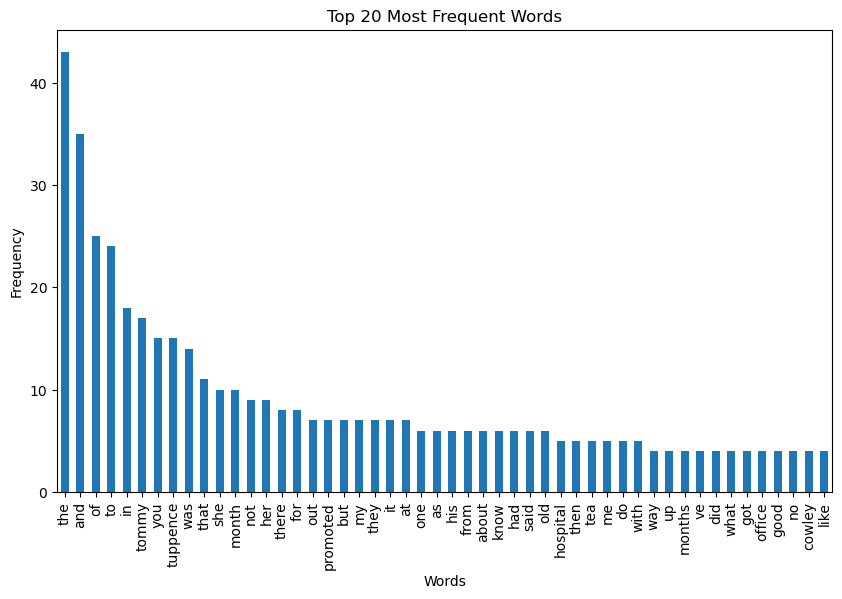

In [14]:
import matplotlib.pyplot as plt

bow_matrix = bow_vectorizer.transform([preprocessed_target_chunks[1][0]]) 
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.head()
word_counts = bow_df.sum(axis=0)
sorted_word_counts = word_counts.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sorted_word_counts.head(50).plot(kind='bar')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

In [15]:
bow_matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X = []
y = []

for item in preprocessed_target_chunks:
    X.append(bow_vectorizer.transform([item[0]]).toarray().flatten())
    y.append(1)


for item in preprocessed_other_chunks:
    X.append(bow_vectorizer.transform([item[0]]).toarray().flatten())
    y.append(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

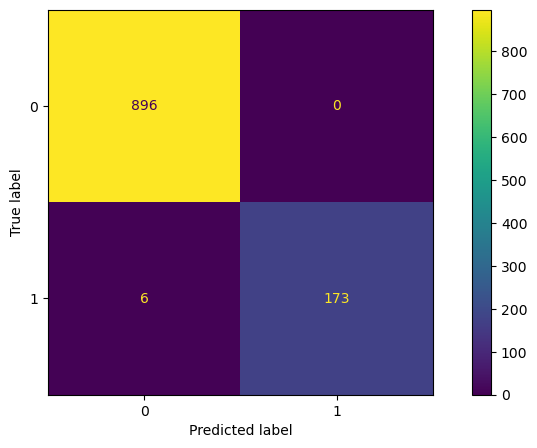

In [17]:
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

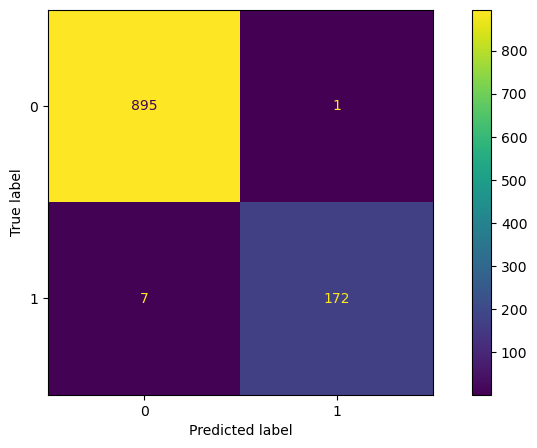

In [18]:
from sklearn.svm import SVC

svm_classifier = SVC(gamma='auto', kernel='linear')
svm_classifier.fit(X_train, y_train)
pred = svm_classifier.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

In [19]:
X = []
y = []

for item in preprocessed_target_chunks:
    X.append(tfidf_vectorizer.transform([item[0]]).toarray().flatten())
    y.append(1)


for item in preprocessed_other_chunks:
    X.append(tfidf_vectorizer.transform([item[0]]).toarray().flatten())
    y.append(0)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

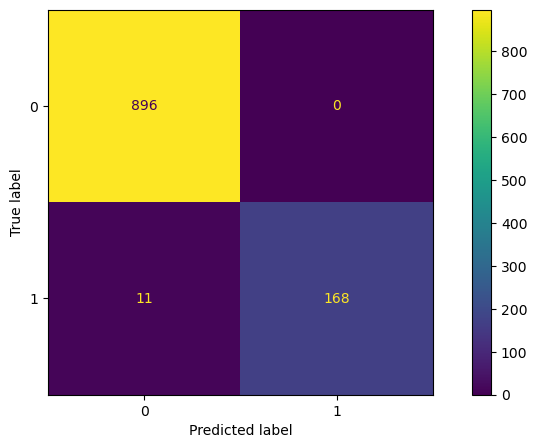

In [23]:
from sklearn.linear_model import RidgeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

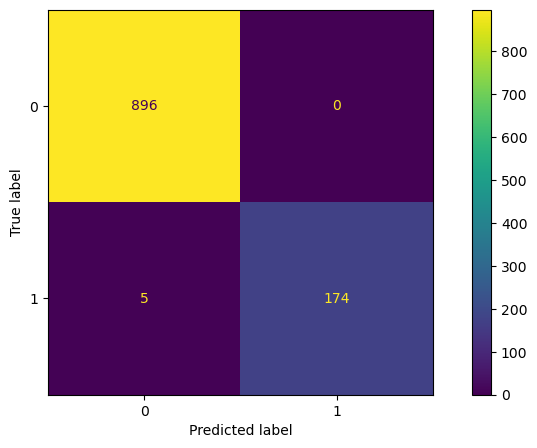

In [22]:
from sklearn.svm import SVC

svm_classifier = SVC(gamma='auto', kernel='linear')
svm_classifier.fit(X_train, y_train)
pred = svm_classifier.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

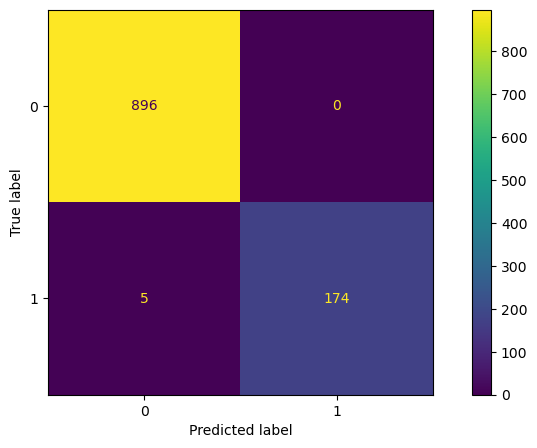

In [26]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth=10, n_estimators=20, max_features=1, random_state=42)
rf_clf.fit(X_train, y_train)
pred = svm_classifier.predict(X_test)
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)

In [27]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, pred)

np.float64(0.9860335195530726)